In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
res_file = "n_pos=200_time_q=0.9_data_path=ml-1m.zip_max_fails=2.csv"

In [3]:
res = pd.read_csv(res_file)
res.head()

,label,HR,r_user,r_item,r_pos,projected,update_order,iters
0,original,0.080035,24,64,4,False,"(2, 0, 1)",5
1,coreless,0.076517,32,32,4,False,"(1, 2, 0)",4
2,coreless,0.051891,96,48,8,False,"(2, 1, 0)",8
3,projected,0.033421,32,24,24,True,"(2, 1, 0)",3
4,coreless,0.024626,128,64,16,False,"(2, 1, 0)",3


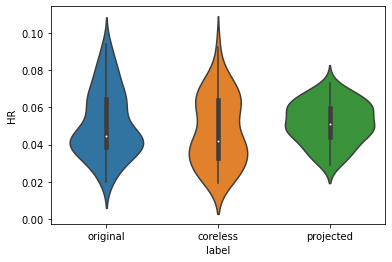

In [4]:
sns.violinplot(data=res, x='label', y='HR');

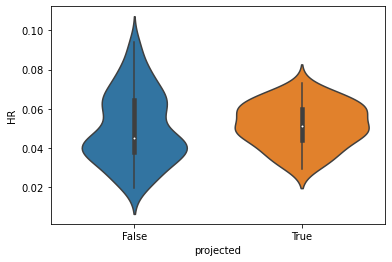

In [5]:
sns.violinplot(data=res, x='projected', y='HR');

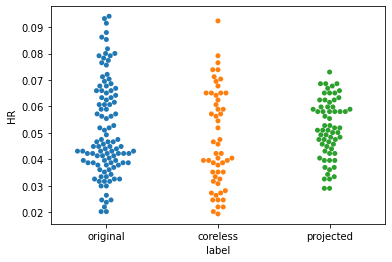

In [6]:
sns.swarmplot(data=res, x='label', y='HR');

In [7]:
reshaped_res = (
    res
    .assign(mlrank=lambda x: x[["r_user", "r_item", "r_pos"]].apply(tuple, axis=1))
    .set_index(['mlrank', 'update_order', 'label'])
    ['HR']
    .unstack('update_order')
    .reset_index()
    .assign(
        HR_best = lambda x: x.iloc[:, -6:].apply(np.max, axis=1),
    )
    .assign(
        rank_prod = lambda x: x['mlrank'].apply(np.prod),
    )
    .sort_values(['HR_best', 'label', 'rank_prod', 'mlrank'], ascending=False)
    .drop('rank_prod', axis=1)
)
reshaped_res.head()

update_order,mlrank,label,"(0, 1, 2)","(0, 2, 1)","(1, 0, 2)","(1, 2, 0)","(2, 0, 1)","(2, 1, 0)",HR_best
69,"(48, 128, 4)",original,0.094107,NaN,NaN,NaN,0.081794,NaN,0.094107
110,"(64, 192, 8)",original,0.093228,NaN,NaN,NaN,NaN,NaN,0.093228
133,"(96, 128, 4)",coreless,NaN,NaN,NaN,NaN,NaN,0.092348,0.092348
108,"(64, 192, 4)",original,NaN,NaN,0.091469,NaN,NaN,NaN,0.091469
134,"(96, 128, 8)",original,0.087951,NaN,NaN,NaN,0.069481,NaN,0.087951


In [8]:
res.HR.max()

0.0941072999120492

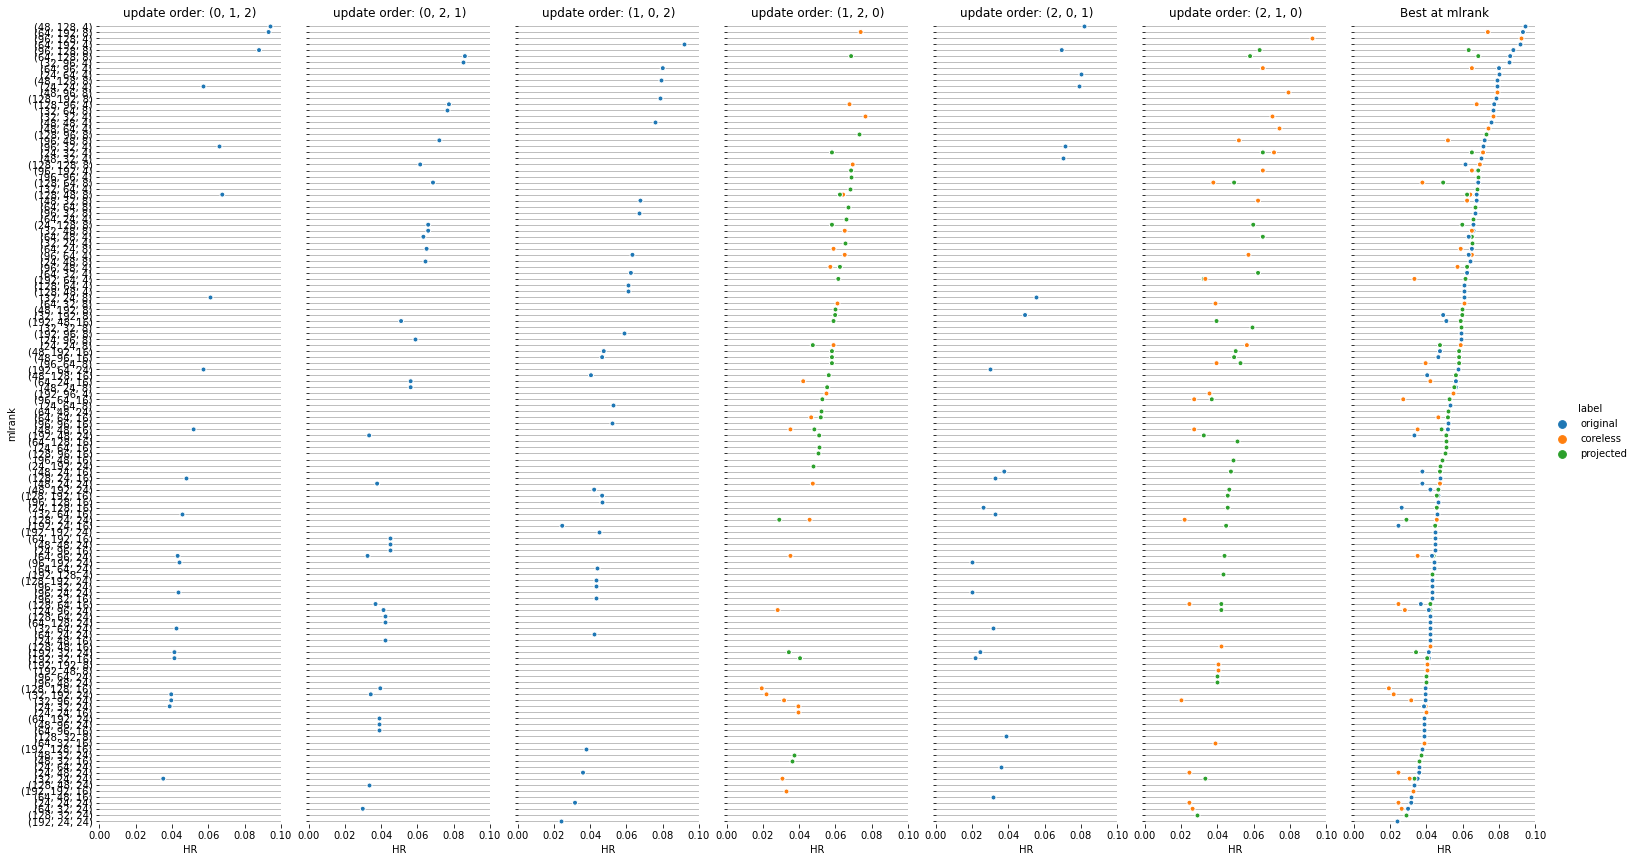

In [9]:
g = sns.PairGrid(
      data=reshaped_res,
      x_vars=reshaped_res.columns[-7:],
      y_vars=["mlrank"],
      height=12,
      aspect=.25,
      hue='label'
)
# Draw a dot plot using the stripplot function
g.map(
      sns.stripplot,
      size=5,
      orient="h",
      jitter=False,
      # palette="flare_r",
      linewidth=1,
      edgecolor="w",
)

titles = [f'update order: {col}' for col in reshaped_res.columns[-7:-1]] + ['Best at mlrank']
for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

g.set(xlim=(0, 0.1), xlabel="HR")
g.add_legend();

## Experiment Completion

In [10]:
from polara.evaluation.pipelines import random_grid
from hooi import valid_mlrank

grid = dict(
        r_user = [24, 32, 48, 64, 96, 128, 192],
        r_item = [24, 32, 48, 64, 96, 128, 192],
        r_pos = [4, 8, 16, 24],
        projected = [True, False],
        update_order = [(2, 1, 0), (1, 2, 0), (0, 1, 2), (1, 0, 2), (2, 0, 1), (0, 2, 1)]
    )

def skip_config(config):
    *mlrank, projected, update_order = config
    if not valid_mlrank(mlrank):
        return True
    if projected and update_order[-1] != 0:
        return True    
    

param_grid, param_names = random_grid(grid, n=0, skip_config=skip_config)

In [11]:
print(f'{res.shape[0]/ len(param_grid):.2%}')

15.52%
